<a href="https://colab.research.google.com/github/Trezeno/TTDS_Assignment/blob/main/TTDS_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TTDS Assignment Submission

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Data and Datasets
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

# Sampling
from imblearn.over_sampling import SMOTE

# Clustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

# K-NN
from sklearn.impute import KNNImputer

# Validation methods
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# Hyper-parameter optimisation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Feature selection & feature engineering
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

# Stats
from scipy.stats import randint as sp_randint
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import shapiro     # Shapiro Wilk
from scipy.stats import normaltest  # D’Agostino’s K^2
from scipy.stats import anderson    # Anderson-Darling
from scipy.stats import ttest_ind    # independent student t-test; assumes normality
from scipy.stats import mannwhitneyu # non-parametric; doesn't assume normality

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.tree import export_graphviz

# Utils
import pprint
import numpy as np
from time import time
import openpyxl

sns.set_theme()

In [59]:
# Other useful functions to aid in machine learning
# Utility function to report best scores - taken from lab 08 Machine Learning unit - To aid with GridSearchCV and finding best hyper parameters to use
def report(results, rank_metric='score', n_top=3):
    """
    Utility function to report best scores.
    :param results: the cv_results_ data structure from the optimisation algorithm
    :param rank_metric: name of the metric to report results for
    :param n_top: the number of top results to report
    """
    print("\nModels ranked according to", rank_metric)
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_" + rank_metric] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.2f} (+/- {1:.2f})".format(
                  results["mean_test_" + rank_metric][candidate],
                  results["std_test_" + rank_metric][candidate]*2))
            print("Params: {0}".format(results['params'][candidate]))
            print("")

# For aid with validating models - taken from lab 06
def validate_model(X, y, model, num_runs=1000, test_size=0.2, output=True):
    """
    Performs hold-out validation of a given model on the dataset provided (X, y).
    The default number of runs is 1000, and the default training/test split is 80/20.
    """

    # arrays for storing performance metrics; accuracy, precision and recall
    acc_list = np.array([])
    prec_list = np.array([])
    rec_list = np.array([])

    # capturing the start-time
    start_time = time()

    if output:
        print("Starting model validation")

    # runing `num_runs` number of validation runs of data splitting, training and testing
    for x in range(num_runs):
        # Hold-out validation - default 80% training and 20% testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=None)

        # Training and testing the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Appending performance metrics to arrays created above
        acc_list = np.append(acc_list, accuracy_score(y_test, y_pred))
        prec_list = np.append(prec_list, precision_score(y_test, y_pred, average='macro'))
        rec_list = np.append(rec_list, recall_score(y_test, y_pred, average='macro'))

    # capturing the end-time and printing out
    end_time = time()

    if output:
        print("Completed %d validation runs in %.2f seconds\n" % (num_runs, end_time - start_time))

    return acc_list, prec_list, rec_list

# For aid with validating models - taken from lab 06
result_df = pd.DataFrame(columns=['Model','Accuracy','Precision','Recall'])

def add_result(model_name, acc_list, prec_list, rec_list):
    """
    Add a result row to a pandas dataframe (created above) for a model with name (model_name).
    mse_list, mae_list and me_list are array lists of performance results from different hold-out validation runs,
    coming from the validate_model() function, above.
    """
    global result_df # doing this to be able to access the gloval dataframe defined above the function

    new_row = {'Model':model_name, 'Accuracy':acc_list.mean(), 'Precision':prec_list.mean(), 'Recall':rec_list.mean()}
    result_df = pd.concat([result_df, pd.Series(new_row).to_frame().T])

    return result_df

def print_results(acc_list, prec_list, rec_list):
    """
    Prints out the mean ACCURACY, PRECISION and RECALL + 2 x standard deviation (STD).
    We multiply the STD by 2 because 95% of the data around the mean is within 2 standard deviations,
    so it gives us a good idea of the range of values around the mean.
    """
    print("ACC:   %0.2f (+/- %0.2f)" % (acc_list.mean(), acc_list.std() * 2))
    print("PREC:  %0.2f (+/- %0.2f)" % (prec_list.mean(), prec_list.std() * 2))
    print("REC:   %0.2f (+/- %0.2f)" % (rec_list.mean(), rec_list.std() * 2))

def clear_results():
    """
    Clears the result dataframe.
    """
    global result_df
    result_df = pd.DataFrame(columns=['Model','Accuracy','Precision','Recall'])

In [3]:
df = pd.read_csv("/content/drive/MyDrive/TTDS/Assignment_Data/diabetes_binary_health_indicators_BRFSS2015.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [5]:
pd.set_option('display.max_columns', 22)
df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,0.056197,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,0.230302,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [6]:
df["Sex"].value_counts()

Sex
0.0    141974
1.0    111706
Name: count, dtype: int64

Text(0.5, 0, '')

<Figure size 640x480 with 0 Axes>

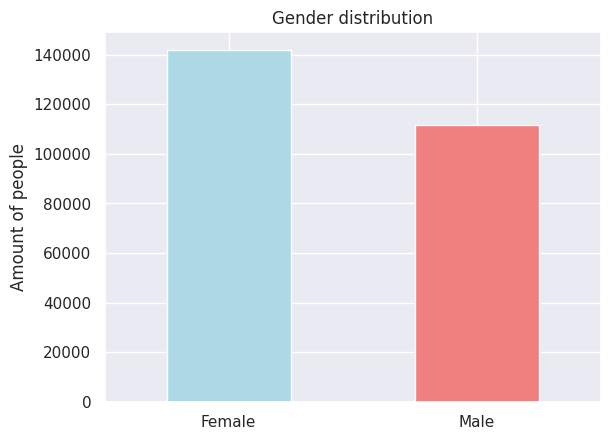

In [7]:
fig = plt.figure()
fig, ax = plt.subplots()
plt.title("Gender distribution")
df["Sex"].value_counts().plot(kind="bar", color=["lightblue", "lightcoral"])
ax.set_xticklabels(["Female", "Male"], rotation=0)
ax.set_ylabel("Amount of people")
ax.set_xlabel("")

<Figure size 640x480 with 0 Axes>

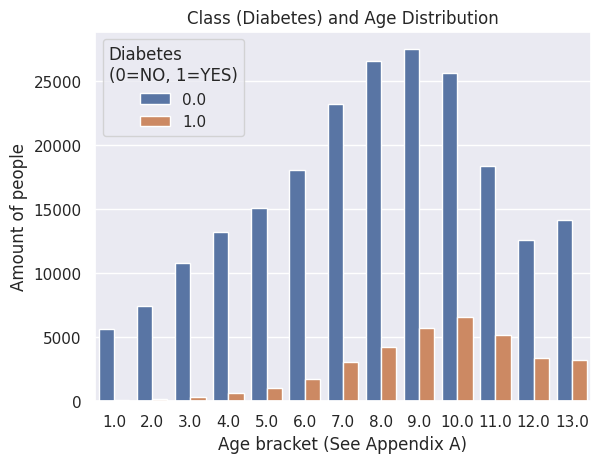

In [8]:
fig = plt.figure()
fig, ax = plt.subplots()
sns.countplot(x='Age', data=df, hue='Diabetes_binary')
plt.title('Class (Diabetes) and Age Distribution')
ax.set_ylabel("Amount of people")
ax.set_xlabel("Age bracket (See Appendix A)")
plt.legend(title="Diabetes\n(0=NO, 1=YES)")


In [9]:
print(df.isnull().sum())

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


In [10]:
print(df.duplicated().value_counts())
df = df.drop_duplicates()
print(df.duplicated().value_counts())

False    229474
True      24206
Name: count, dtype: int64
False    229474
Name: count, dtype: int64


In [11]:
df["Diabetes_binary"].value_counts()

Diabetes_binary
0.0    194377
1.0     35097
Name: count, dtype: int64

Text(0.5, 0, '')

<Figure size 640x480 with 0 Axes>

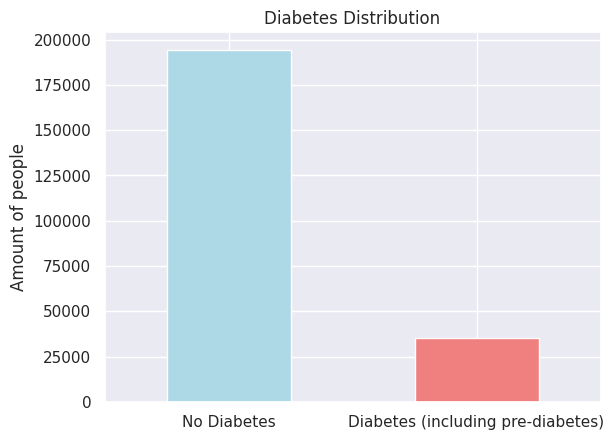

In [12]:
fig = plt.figure()
fig, ax = plt.subplots()
plt.title("Diabetes Distribution")
df["Diabetes_binary"].value_counts().plot(kind="bar", color=["lightblue", "lightcoral"])
ax.set_xticklabels(["No Diabetes", "Diabetes (including pre-diabetes)"], rotation=0)
ax.set_ylabel("Amount of people")
ax.set_xlabel("")

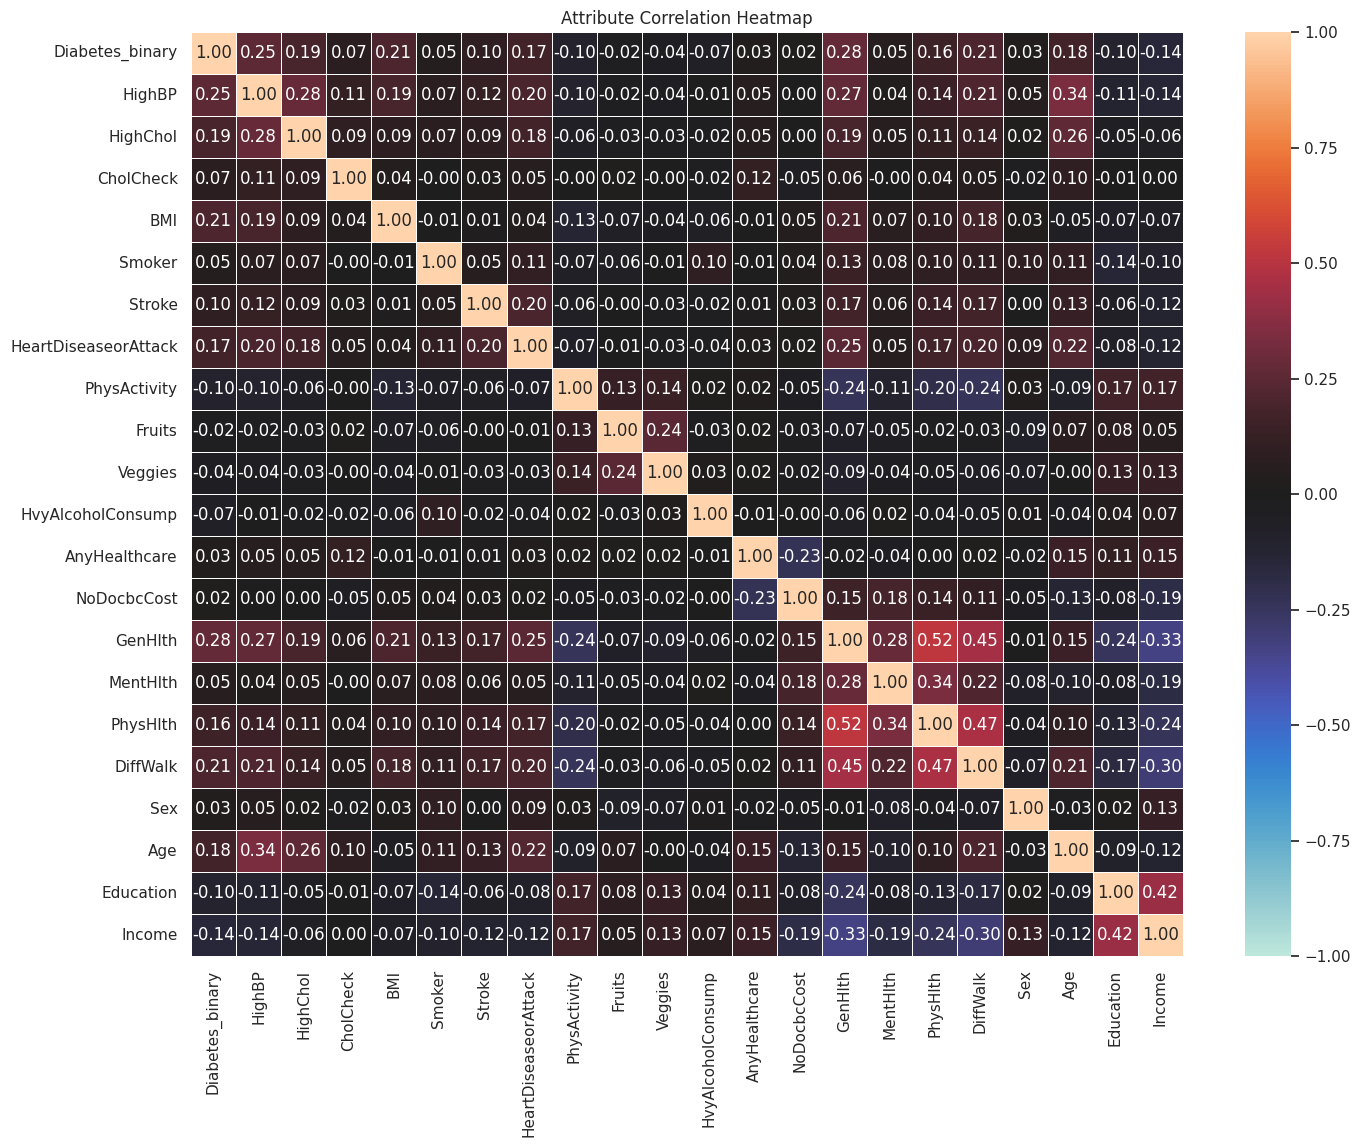

In [13]:
plt.figure(figsize=(16, 12))
sns.heatmap(data=df.corr(), annot=True, linewidths=.5, fmt= '.2f', vmin=-1, vmax=1, center=0)
plt.title('Attribute Correlation Heatmap')
plt.show()

In [14]:
# Splitting the dataset into feature matrix (X) and the class (y)
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Now going to check feature importance for this dataset
model = DecisionTreeClassifier()

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')

start_time = time()
rfecv.fit(X_scaled, y)
end_time = time()

# Printing out the results
print("RFECV took %.2f seconds to identify %d features" %
      ((end_time - start_time), rfecv.n_features_))
print(rfecv.ranking_)

RFECV took 112.55 seconds to identify 1 features
[ 7 17 21  1 11 18 16 10  9 12 20 19 15  8  4  3 13 14  2  6  5]


In [16]:
list_of_feature_names = []
for feature in df:
  list_of_feature_names.append(feature)
list_of_feature_names.remove("Diabetes_binary")
print(list_of_feature_names)

['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


In [17]:
# Creating a DataFrame to display the original columns and their ranking of feature importance
feature_ranking_df = pd.DataFrame()
feature_ranking_df["feature_name"] = list_of_feature_names
feature_ranking_df["ranking"] = rfecv.ranking_

feature_ranking_df = feature_ranking_df.sort_values(by="ranking", ascending=True)
feature_ranking_df

,feature_name,ranking
3,BMI,1
18,Age,2
15,PhysHlth,3
14,MentHlth,4
20,Income,5
19,Education,6
0,HighBP,7
13,GenHlth,8
8,Fruits,9
7,PhysActivity,10


In [18]:
# Instantiating a RandomForest classifier
model = RandomForestClassifier(n_estimators=200, random_state=None)

# 5-fold cross validation
scores = cross_validate(model, X_scaled, y, cv=5, return_estimator=True)

# Getting the trained model from the 1st fold
estimator = scores["estimator"][0]

In [19]:
# Creating a DataFrame to display the original columns and their importance
feature_importance_df = pd.DataFrame()
feature_importance_df['Feature Name'] = list_of_feature_names
feature_importance_df['Level Of Importance'] = estimator.feature_importances_

feature_importance_df = feature_importance_df.sort_values(by='Level Of Importance', ascending=True)
#feature_importance_df

<Axes: title={'center': 'Random Forest Feature Importance'}, ylabel='Feature Name'>

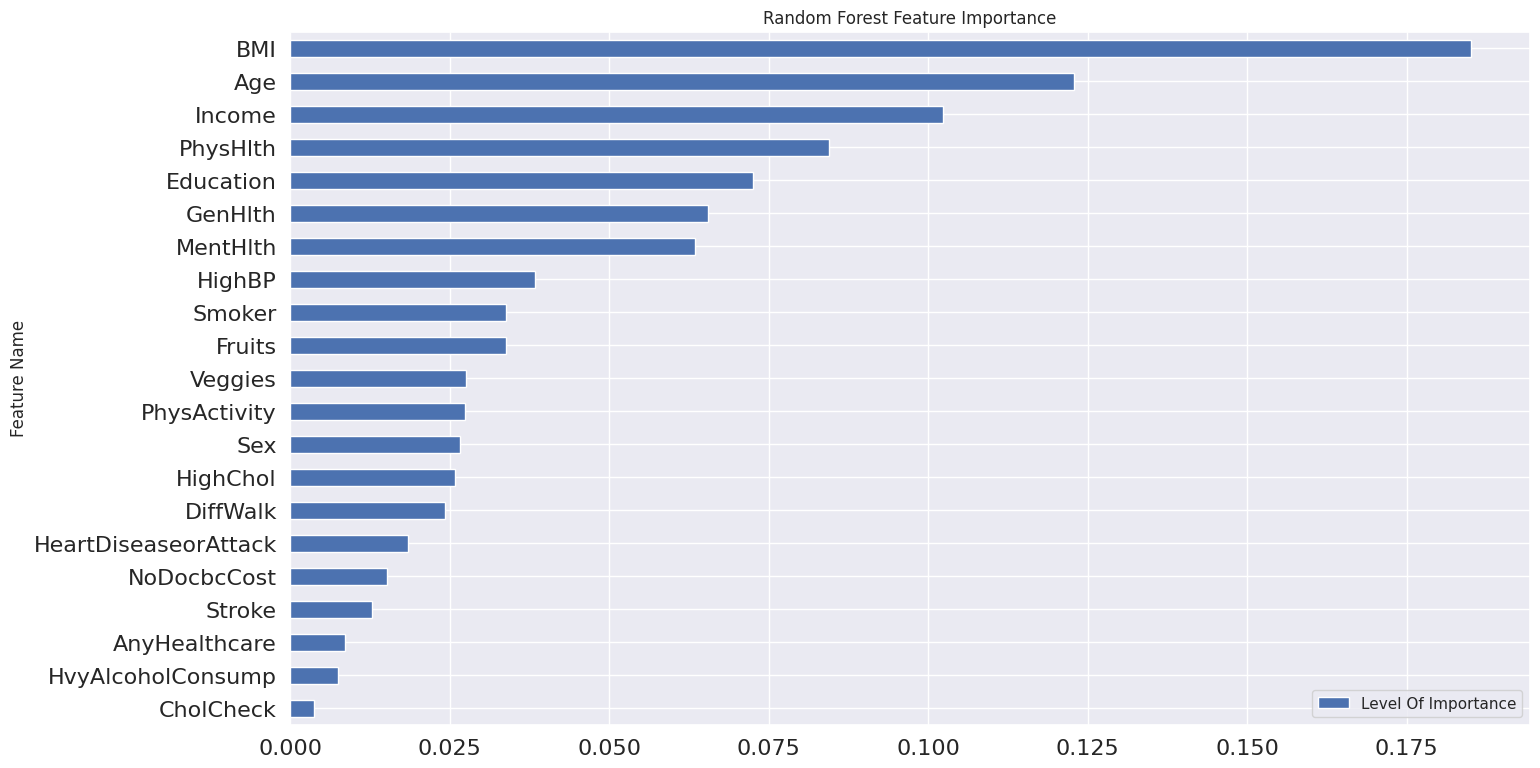

In [20]:
# Plotting a horizontal bar chart to show all features importance
feature_importance_df.plot(kind='barh',
                           x='Feature Name',
                           y='Level Of Importance',
                           title='Random Forest Feature Importance',
                           xlabel='',
                           figsize=(16, 9),
                           fontsize=16)

In [21]:
# Comparing the two feature importance rankings etc, will drop a few columns that don't seem to have much importance
columns_to_drop = ["CholCheck", "HvyAlcoholConsump", "AnyHealthcare", "Stroke", "NoDocbcCost", "HeartDiseaseorAttack"]

df = df.drop(columns=columns_to_drop)

In [22]:
df.duplicated().value_counts()
df = df.drop_duplicates()

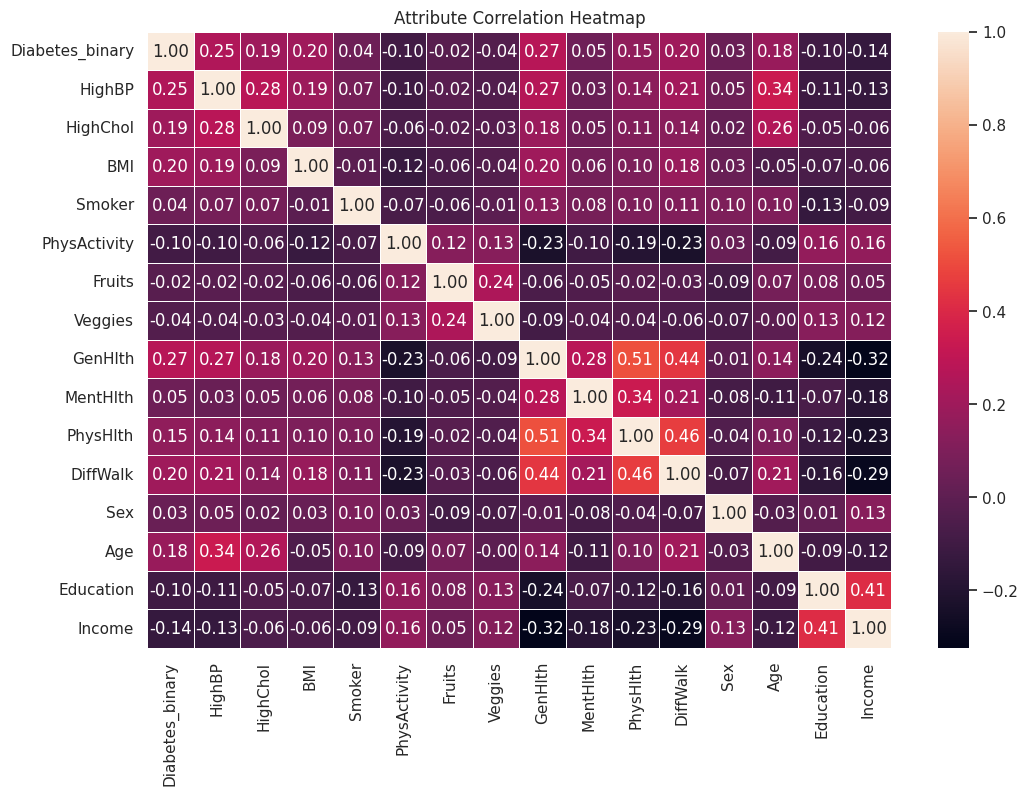

In [23]:
plt.figure(figsize=(12, 8))
sns.heatmap(data=df.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.title('Attribute Correlation Heatmap')
plt.show()

In [24]:
# Removing redundant (highly correlated) features
columns_to_drop = ["Education", "DiffWalk", "PhysHlth"]
df = df.drop(columns=columns_to_drop)

In [25]:
df.duplicated().value_counts()
df = df.drop_duplicates()

In [26]:
df.describe()

,Diabetes_binary,HighBP,HighChol,BMI,Smoker,PhysActivity,Fruits,Veggies,GenHlth,MentHlth,Sex,Age,Income
count,188383.000000,188383.000000,188383.000000,188383.000000,188383.000000,188383.000000,188383.000000,188383.000000,188383.000000,188383.000000,188383.000000,188383.000000,188383.000000
mean,0.177229,0.477278,0.455848,29.141685,0.481917,0.692515,0.581045,0.763599,2.710085,4.205767,0.434689,8.061301,5.653068
std,0.381864,0.499485,0.498048,7.182812,0.499674,0.461453,0.493389,0.424873,1.087622,8.296031,0.495717,3.131086,2.140116
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,6.000000,4.000000
50%,0.000000,0.000000,0.000000,28.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,8.000000,6.000000
75%,0.000000,1.000000,1.000000,32.000000,1.000000,1.000000,1.000000,1.000000,3.000000,4.000000,1.000000,10.000000,8.000000
max,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,1.000000,13.000000,8.000000


In [39]:
df["Diabetes_binary"].value_counts()

Diabetes_binary
0.0    154996
1.0     33387
Name: count, dtype: int64

In [43]:
# Splitting the dataset into feature matrix (X) and the class (y) - Done again after removing some features etc
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [46]:
# SMOTE to handle class imbalance
smote = SMOTE(random_state=42)

X_after_smote, y_after_smote = smote.fit_resample(X, y)

balanced_df = pd.DataFrame(X_after_smote, columns=X.columns)
balanced_df["Diabetes_binary"] = y_after_smote

In [47]:
balanced_df.describe()

,HighBP,HighChol,BMI,Smoker,PhysActivity,Fruits,Veggies,GenHlth,MentHlth,Sex,Age,Income,Diabetes_binary
count,309992.000000,309992.000000,309992.000000,309992.000000,309992.000000,309992.000000,309992.000000,309992.000000,309992.000000,309992.000000,309992.000000,309992.000000,309992.000000
mean,0.591739,0.545205,30.273907,0.495953,0.669981,0.583952,0.766581,2.946964,4.392161,0.447724,8.567000,5.451600,0.500000
std,0.480629,0.485168,7.432475,0.485934,0.456116,0.479013,0.409329,1.077767,8.634321,0.484160,2.901857,2.176671,0.500001
min,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.744473,2.000000,0.000000,0.000000,7.000000,4.000000,0.000000
50%,1.000000,1.000000,29.000000,0.452799,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,9.000000,6.000000,0.500000
75%,1.000000,1.000000,34.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,1.000000,11.000000,7.000000,1.000000
max,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,1.000000,13.000000,8.000000,1.000000


In [54]:
# Re-splitting the dataset into feature matrix (X) and the class (y) - Done again after handling class-imbalance
# This will be used to find best hyper-parameters for upcoming models
# Found an easier way of doing it as opposed to slicing, keeping old and new for future reference
X = balanced_df.drop(columns="Diabetes_binary")
y = balanced_df["Diabetes_binary"]

In [56]:
# Checking best Logistic Regression hyper-parameters - Taken from lab 08 and changed around a little
model = LogisticRegression()

# defining parameter grid
param_grid = {"class_weight": ["balanced"],
              "multi_class": ["ovr", "multinomial"],
              "solver": ["newton-cg", "sag", "saga", "newton-cholesky’"]}

# defining multiple metrics for scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'prec_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'rec_macro': make_scorer(recall_score, average='macro', zero_division=0)
}

# run grid search
print("\n> STARTING GRID SEARCH ...")
n_folds = 5
grid_search = GridSearchCV(model,
                           param_grid=param_grid,
                           cv=n_folds,
                           scoring=scoring,
                           refit='prec_macro')
start = time()
grid_search.fit(X, y)

print("> GRID SEARCH COMPLETE")
print("\nGridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

# Get the best model according to each of the 3 metrics used
report(grid_search.cv_results_, 'accuracy', n_top=1)
report(grid_search.cv_results_, 'prec_macro', n_top=1)
report(grid_search.cv_results_, 'rec_macro', n_top=1)

try:
    print("Best score: %0.2f " % (grid_search.best_score_))
except:
    print("Best score not available (refit set to False presumably)")


> STARTING GRID SEARCH ...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklear

> GRID SEARCH COMPLETE

GridSearchCV took 225.13 seconds for 8 candidate parameter settings.

Models ranked according to accuracy
Model with rank: 1
Mean validation score: 0.72 (+/- 0.01)
Params: {'class_weight': 'balanced', 'multi_class': 'ovr', 'solver': 'saga'}


Models ranked according to prec_macro
Model with rank: 1
Mean validation score: 0.72 (+/- 0.01)
Params: {'class_weight': 'balanced', 'multi_class': 'ovr', 'solver': 'saga'}


Models ranked according to rec_macro
Model with rank: 1
Mean validation score: 0.72 (+/- 0.01)
Params: {'class_weight': 'balanced', 'multi_class': 'ovr', 'solver': 'saga'}

Best score: 0.72 


In [29]:
# Searching for best parameters (Decision Tree)
# Machine Learning Unit - Lab 08 - Helped with code to do the below
model = DecisionTreeClassifier()

# defining parameter grid
param_grid = {"max_depth": [2, 4, 6, 8, None],
              "max_features": [2, 4, 6, 8, 10],
              "min_samples_split": [2, 4, 6, 8, 10],
              "criterion": ["gini", "entropy"],
              "splitter": ["best", "random"]}

# defining multiple metrics for scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'prec_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'rec_macro': make_scorer(recall_score, average='macro', zero_division=0)
}

# run grid search
print("\n> STARTING GRID SEARCH ...")
n_folds = 10
grid_search = GridSearchCV(model,
                           param_grid=param_grid,
                           cv=n_folds,
                           scoring=scoring,
                           refit='prec_macro')
start = time()
grid_search.fit(X_scaled, y)

print("> GRID SEARCH COMPLETE")
print("\nGridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

# Get the best model according to each of the 3 metrics used
report(grid_search.cv_results_, 'accuracy', n_top=1)
report(grid_search.cv_results_, 'prec_macro', n_top=1)
report(grid_search.cv_results_, 'rec_macro', n_top=1)

try:
    print("Best score: %0.2f " % (grid_search.best_score_))
except:
    print("Best score not available (refit set to False presumably)")


> STARTING GRID SEARCH ...
> GRID SEARCH COMPLETE

GridSearchCV took 1180.50 seconds for 500 candidate parameter settings.

Models ranked according to accuracy
Model with rank: 1
Mean validation score: 0.83 (+/- 0.00)
Params: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 8, 'min_samples_split': 8, 'splitter': 'best'}


Models ranked according to prec_macro
Model with rank: 1
Mean validation score: 0.72 (+/- 0.14)
Params: {'criterion': 'gini', 'max_depth': 6, 'max_features': 8, 'min_samples_split': 6, 'splitter': 'random'}


Models ranked according to rec_macro
Model with rank: 1
Mean validation score: 0.57 (+/- 0.01)
Params: {'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_split': 10, 'splitter': 'best'}

Best score: 0.72 


In [68]:
# Support Vector Machine (SVM)

In [65]:
# Running models and validation of them
# Doing all at once with x number of hold-out validation runs specified below
models = {
    "LR" : LogisticRegression(class_weight='balanced', multi_class='ovr', solver='saga'),
}

num_runs = 50

for model_name, model in models.items():
  # arrays for storing performance metrics
  acc_list, prec_list, rec_list = validate_model(X, y, model, num_runs)

  # save the result
  add_result(model_name, acc_list, prec_list, rec_list)

  # printing out the performance metrics
  print(model_name, ": ")
  print_results(acc_list, prec_list, rec_list)
  print("")

Starting model validation
Completed 50 validation runs in 547.97 seconds

LR : 
ACC:   0.72 (+/- 0.00)
PREC:  0.72 (+/- 0.00)
REC:   0.72 (+/- 0.00)



In [43]:
# Performance metrics
# Accuracy
train_accuracy = accuracy_score(y_pred, y_train_binary)
print("Training accuracy: ", train_accuracy*100)

val_accuracy = cross_val_score(model, X_train_all_scaled, y_train_binary, cv=3, scoring='accuracy')
print("Validation accuracy: ", val_accuracy)

Training accuracy:  87.59008383311817
Validation accuracy:  [0.83298743 0.83254621 0.83282402]


In [45]:
# Performance metrics 2
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
# Confusion matrix
y_train_pred = cross_val_predict(model, X_train_all_scaled, y_train_binary, cv=3)
confusion_matrix(y_train_binary, y_train_pred)

array([[147122,   8442],
       [ 22255,   5760]])

In [47]:
# Performance metrics 3
from sklearn.metrics import f1_score
# F1 Score
f1_score(y_train_binary, y_train_pred)

0.2728758556979416